In [2]:
from tensorflow_graph_in_jupyter import show_graph
import numpy as np
import tensorflow as tf

D:\Users\snandan.ORADEV\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "D:\Python_work\deeplearning\RNNs"
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


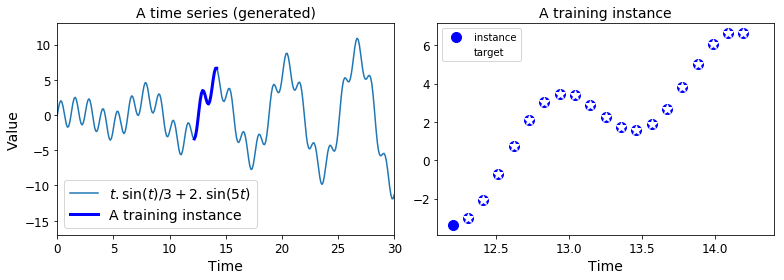

In [6]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [7]:
X_batch, y_batch = next_batch(1, n_steps)

In [8]:
np.c_[X_batch[0], y_batch[0]]

array([[-2.38449865, -1.64853323],
       [-1.64853323, -0.57310738],
       [-0.57310738,  0.62594654],
       [ 0.62594654,  1.70425567],
       [ 1.70425567,  2.44824578],
       [ 2.44824578,  2.72691179],
       [ 2.72691179,  2.52334998],
       [ 2.52334998,  1.9383373 ],
       [ 1.9383373 ,  1.16508752],
       [ 1.16508752,  0.44137121],
       [ 0.44137121, -0.00927145],
       [-0.00927145, -0.03282511],
       [-0.03282511,  0.41694366],
       [ 0.41694366,  1.2666399 ],
       [ 1.2666399 ,  2.34071128],
       [ 2.34071128,  3.40396554],
       [ 3.40396554,  4.2187304 ],
       [ 4.2187304 ,  4.60266714],
       [ 4.60266714,  4.47308815],
       [ 4.47308815,  3.86693279]])

## Using an OuputProjectionWrapper
Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps 
since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time).
The targets are also sequences of 20 inputs, each containing a sigle value:

In [9]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper.

In [10]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [11]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [12]:

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [13]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [14]:
saver = tf.train.Saver()

In [15]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "D:\Python_work\deeplearning\RNNs\my_time_series_model") # not shown in the book

0 	MSE: 11.967254
100 	MSE: 0.525841
200 	MSE: 0.1495599
300 	MSE: 0.07279411
400 	MSE: 0.06158535
500 	MSE: 0.05938873
600 	MSE: 0.05470166
700 	MSE: 0.047849063
800 	MSE: 0.05107608
900 	MSE: 0.047209196
1000 	MSE: 0.047058314
1100 	MSE: 0.047831465
1200 	MSE: 0.04083041
1300 	MSE: 0.047086805
1400 	MSE: 0.041784383


In [16]:

with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "D:\Python_work\deeplearning\RNNs\my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from D:\Python_work\deeplearning\RNNs\my_time_series_model


In [17]:
y_pred

array([[[-3.407753 ],
        [-2.4575484],
        [-1.1029298],
        [ 0.7815629],
        [ 2.2002175],
        [ 3.126768 ],
        [ 3.4037762],
        [ 3.3489153],
        [ 2.8798013],
        [ 2.2659323],
        [ 1.6447463],
        [ 1.5210768],
        [ 1.8972012],
        [ 2.7159088],
        [ 3.8894904],
        [ 5.140914 ],
        [ 6.142068 ],
        [ 6.666671 ],
        [ 6.6410103],
        [ 6.0725527]]], dtype=float32)

Saving figure time_series_pred_plot


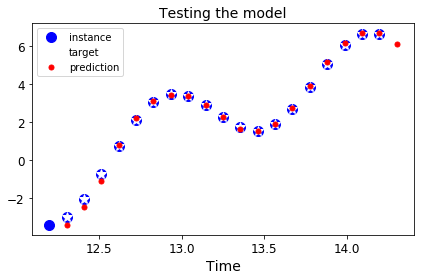

In [18]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an OutputProjectionWrapper

In [19]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [20]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [21]:
n_outputs = 1
learning_rate = 0.001

In [22]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [23]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "D:\Python_work\deeplearning\RNNs\my_time_series_model")

0 	MSE: 13.907029
100 	MSE: 0.5056698
200 	MSE: 0.19735886
300 	MSE: 0.101214476
400 	MSE: 0.06850145
500 	MSE: 0.06291986
600 	MSE: 0.055129297
700 	MSE: 0.049436502
800 	MSE: 0.050434686
900 	MSE: 0.0482007
1000 	MSE: 0.04809868
1100 	MSE: 0.04982501
1200 	MSE: 0.041912545
1300 	MSE: 0.049292978
1400 	MSE: 0.043140374


In [25]:
y_pred

array([[[-3.4332483],
        [-2.4594698],
        [-1.1081185],
        [ 0.6882153],
        [ 2.1105688],
        [ 3.0585155],
        [ 3.5144088],
        [ 3.3531117],
        [ 2.808016 ],
        [ 2.1606152],
        [ 1.662645 ],
        [ 1.5578941],
        [ 1.9173537],
        [ 2.7210245],
        [ 3.8667865],
        [ 5.100083 ],
        [ 6.099999 ],
        [ 6.6480975],
        [ 6.6147423],
        [ 6.022089 ]]], dtype=float32)

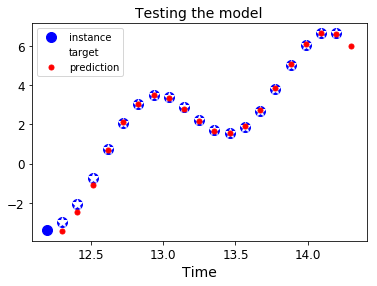

In [26]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [27]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


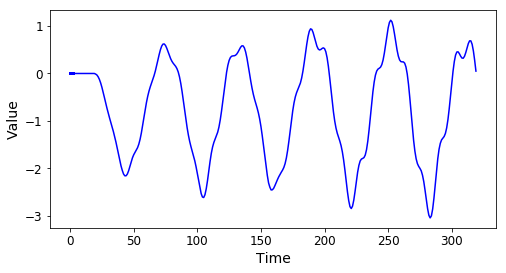

In [28]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


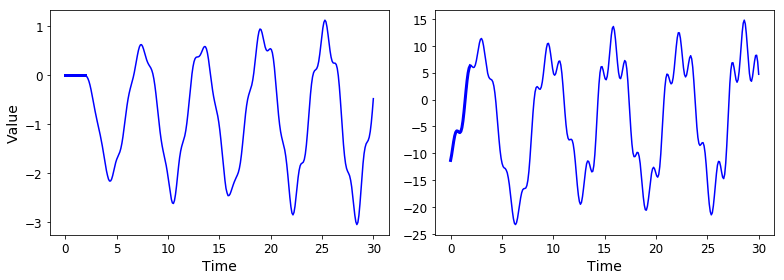

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()